In [70]:
"""pip install scikit-optimize
pip install optuna
pip install fitter"""

'pip install scikit-optimize\npip install optuna\npip install fitter'

In [71]:
#Tratamieto de datos
import pandas as pd 
import numpy as np  
from tabulate import tabulate
# ==============================================================================================================================================================

#   Gráficos 
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
# ==============================================================================================================================================================

#Preprocesado y Modelado
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.ensemble import RandomForestClassifier

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

# Varios
# ==============================================================================================================================================================
import multiprocessing
import random
from itertools import product
from fitter import Fitter, get_common_distributions
# Configuración matplotlib
# ==============================================================================================================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================================================================================================
import warnings
warnings.filterwarnings('ignore')

# Objetivo

Obtener un modelo capaz de predecir si se rechaza o no un canal de res cárnico

In [72]:
data=pd.read_excel(r"D:\Never Urueta\2023\Algoritmos Tesis\Data.xlsx") 

In [73]:
data1 = data.drop(["PBA", "CF", "CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO"], axis=1)

In [74]:
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


### Variable de Respuesta 

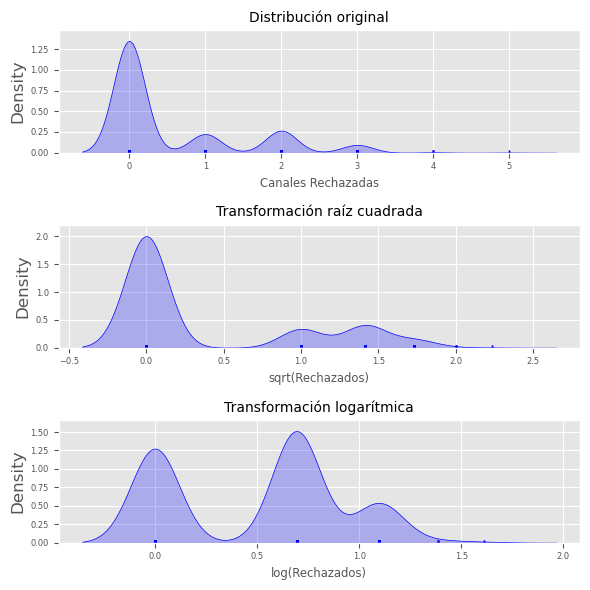

In [75]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 6))
sns.kdeplot(
    data1.Rechazados,
    fill    = True,
    color   = "blue",
    ax      = axes[0]
)
sns.rugplot(
    data1.Rechazados,
    color   = "blue",
    ax      = axes[0]
)
axes[0].set_title("Distribución original", fontsize = 'medium')
axes[0].set_xlabel('Canales Rechazadas', fontsize='small') 
axes[0].tick_params(labelsize = 6)

sns.kdeplot(
    np.sqrt(data1.Rechazados),
    fill    = True,
    color   = "blue",
    ax      = axes[1]
)
sns.rugplot(
    np.sqrt(data1.Rechazados),
    color   = "blue",
    ax      = axes[1]
)
axes[1].set_title("Transformación raíz cuadrada", fontsize = 'medium')
axes[1].set_xlabel('sqrt(Rechazados)', fontsize='small') 
axes[1].tick_params(labelsize = 6)

sns.kdeplot(
    np.log(data1.Rechazados),
    fill    = True,
    color   = "blue",
    ax      = axes[2]
)
sns.rugplot(
    np.log(data1.Rechazados),
    color   = "blue",
    ax      = axes[2]
)
axes[2].set_title("Transformación logarítmica", fontsize = 'medium')
axes[2].set_xlabel('log(Rechazados)', fontsize='small') 
axes[2].tick_params(labelsize = 6)

fig.tight_layout()

### Ditribución de Probabilidad

In [76]:
distribuciones = ['cauchy', 'chi2', 'expon',  'exponpow', 'gamma',
                  'norm', 'powerlaw', 'beta', 'logistic']

fitter = Fitter(data1.Rechazados, distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=10, plot=False)

Fitting 9 distributions: 100%|██████████| 9/9 [00:01<00:00,  7.95it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,118.627433,1281.607504,-5300.091957,inf,0.694282,0.000000e+00
exponpow,126.073559,585.308791,-5183.571905,inf,0.694357,0.000000e+00
beta,152.240519,437.963608,-4815.042027,inf,0.694357,0.000000e+00
chi2,165.332892,459.363260,-4664.695253,inf,0.694357,0.000000e+00
expon,175.167721,790.640503,-4561.655633,inf,0.694357,0.000000e+00
powerlaw,186.088242,386.602081,-4438.345590,inf,0.694357,0.000000e+00
logistic,197.286140,800.580710,-4334.059515,inf,0.372468,7.643201e-239
norm,198.993160,852.109693,-4317.569848,inf,0.417928,2.322199e-303
cauchy,206.734080,9137.146821,-4244.526105,inf,0.351491,6.050174e-212


### Correlación variables numéricas

De archivo ejecutadon con regresión se evidenció una correlación entre dos variables independientes, por lo que procederemos a eñliminar a una, la variable Ocupación

In [77]:
data1 = data1.drop(["Ocupacion"],axis=1)

### Variabes cualitativas

Eliminamos los registros de PBA2 solo quedandonos con PBA1 

In [78]:
data1 = data1.loc[data1["TIPO_CAP_CF"] != "PBA2", :]

In [79]:
data1.loc[data1["Rechazados"] > 0, "Rechazados"] = 1
print(data1.Rechazados.value_counts().sort_index())

0    1259
1     583
Name: Rechazados, dtype: int64


In [80]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('Rechazados', axis = 'columns'),
                                        data1['Rechazados'],
                                        train_size   = 0.67,
                                        random_state = 1234,
                                        
                                        shuffle      = True
                                    )

In [81]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())
print("-----------------------")
print("-----------------------")
print("Partición de test")
print("-----------------------")
print(y_test.describe())

Partición de entrenamento
-----------------------
count    1234.000000
mean        0.321718
std         0.467325
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Rechazados, dtype: float64
-----------------------
-----------------------
Partición de test
-----------------------
count    608.000000
mean       0.305921
std        0.461176
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Rechazados, dtype: float64


## Modelo

### Random Forest

In [88]:
from sklearn.ensemble import RandomForestClassifier
# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestClassifier(n_estimators=10))])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [10, 100, 1000, 10000],
    'modelo__max_features': ['sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
15,10000,log2,20,0.694757,0.019371,1.0,0.0


In [89]:
# Error de test del modelo final
# ==============================================================================
rf_model = grid.best_estimator_
predicciones3 = rf_model.predict(X = X_test)
Accuracy_rf= accuracy_score(y_true  = y_test, y_pred  = predicciones3)
print(f"Accuracy: {Accuracy_rf}")
RMSE_rf = mean_squared_error(y_true  = y_test, y_pred  = predicciones3, squared = False)
print(f"RMSE: {RMSE_rf}")

Accuracy: 0.7549342105263158
RMSE: 0.49504119977400285


### Gradient Boosting Trees

In [90]:
from sklearn.ensemble import GradientBoostingClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__loss': ['log_loss', 'deviance', 'exponential'],
    'modelo__n_estimators': [50, 100, 1000, 5000],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.1, 0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__subsample,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,param_modelo__loss,mean_test_score,std_test_score,mean_train_score,std_train_score
10,0.7,5000,log2,10,deviance,-0.547194,0.026295,0.0,0.0


In [91]:
gbt_model = grid.best_estimator_
predicciones4 = gbt_model.predict(X = X_test)

Accuracy_gbt= accuracy_score(y_true  = y_test, y_pred  = predicciones4)
print(f"Accuracy: {Accuracy_gbt}")
RMSE_gbt = mean_squared_error(y_true  = y_test, y_pred  = predicciones4, squared = False)
print(f"RMSE: {RMSE_gbt}")

Accuracy: 0.7351973684210527
RMSE: 0.5145897701848992


### Árboles de decisión

In [92]:
from sklearn.tree import DecisionTreeClassifier

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', DecisionTreeClassifier())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__criterion': ['gini', 'entropy', 'log_loss'],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__min_samples_split': [1, 2, 10, 500],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 10000],
    'modelo__max_leaf_nodes'   : [1, 10, 20, 100, 10000],
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train, modelo__sample_weight = X_train["Ti1"])

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

,param_modelo__min_samples_split,param_modelo__max_leaf_nodes,param_modelo__max_features,param_modelo__max_depth,param_modelo__criterion,mean_test_score,std_test_score,mean_train_score,std_train_score
1,500,10,auto,10000,gini,-0.570751,0.028203,-0.567581,0.006408


In [93]:
dtree_model = grid.best_estimator_
predicciones5 = gbt_model.predict(X = X_test)

Accuracy_dtree= accuracy_score(y_true  = y_test, y_pred  = predicciones5)
print(f"Accuracy: {Accuracy_dtree}")
RMSE_dtree = mean_squared_error(y_true  = y_test, y_pred  = predicciones5, squared = False)
print(f"RMSE: {RMSE_dtree}")

Accuracy: 0.7351973684210527
RMSE: 0.5145897701848992


## Stacking

In [100]:
from sklearn.ensemble import StackingClassifier

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')


# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestClassifier(
                                         n_estimators = 1000,
                                         max_features = 'log2',
                                         max_depth    = 20
                                        )
                     )])

pipe_gbt = Pipeline([('preprocessing', preprocessor),
                     ('Gradient_Boosting_Trees', GradientBoostingClassifier(
                                         subsample = 0.7,                 
                                         n_estimators = 5000,
                                         max_features = 'log2',
                                         max_depth    = 10,
                                         loss= 'deviance'
                                        )
                     )])

pipe_dtree = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', DecisionTreeClassifier(
                                         min_samples_split = 500,                 
                                         max_leaf_nodes = 10,
                                         max_features = 'auto',
                                         max_depth    = 1000,
                                         criterion = 'gini'
                                        )
                     )])

In [111]:
# Definición y entrenamiento del StackingClassifier
# ==============================================================================
estimators = [('random_forest', pipe_rf),
              ('Gradient_Boosting_Trees', pipe_gbt),
              ('Decision_Tree', pipe_dtree),
              ]

stacking_cla= StackingClassifier(estimators=estimators,
                                       final_estimator=LogisticRegression())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_cla.fit(X = X_train, y = y_train)

In [112]:
stacking_model = stacking_cla
predicciones7 = stacking_model.predict(X = X_test)

Accuracy_stacking= accuracy_score(y_true  = y_test, y_pred  = predicciones7)
print(f"Accuracy: {Accuracy_stacking}")
RMSE_stacking = mean_squared_error(y_true  = y_test, y_pred  = predicciones7, squared = False)
print(f"RMSE: {RMSE_stacking}")

Accuracy: 0.7417763157894737
RMSE: 0.5081571451928294


Text(0.5, 0, 'Test accuracy')

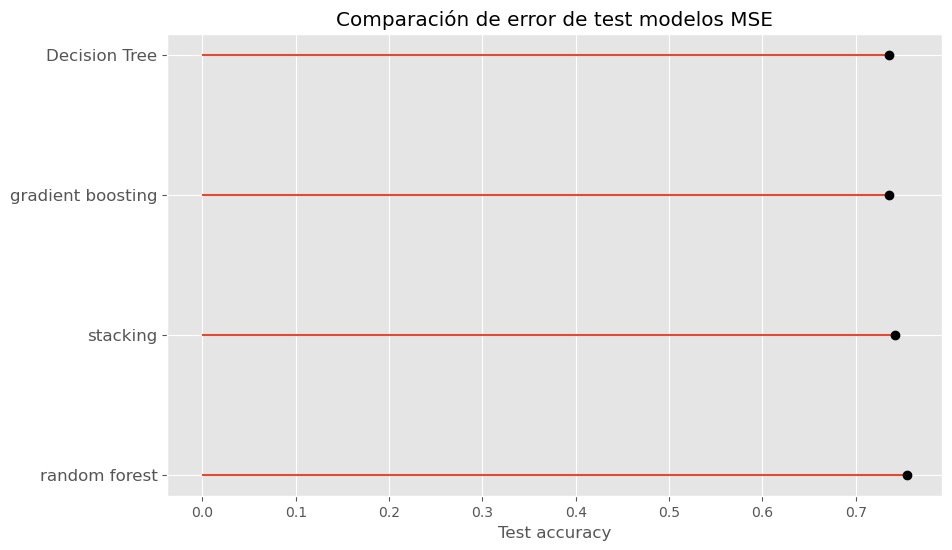

In [115]:
error_modelos = pd.DataFrame({'modelo': ['random forest', 'gradient boosting',"Decision Tree",'stacking'],
                              'Accuracy': [Accuracy_rf, Accuracy_gbt, Accuracy_dtree,  Accuracy_stacking]})
error_modelos = error_modelos.sort_values('Accuracy', ascending=False)


plt.figure(figsize=(10, 6))
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.Accuracy)
plt.plot(error_modelos.Accuracy, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación de error de test modelos MSE')
plt.xlabel('Test accuracy')



<AxesSubplot:>

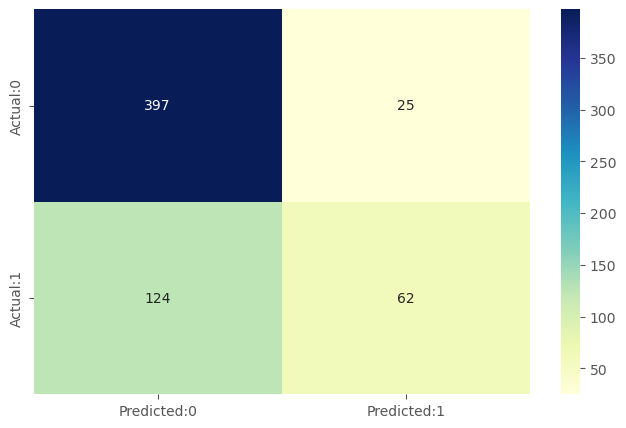

In [117]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,predicciones3)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

In [118]:
VN = cm[1,1]
VP = cm[0,0]
FN = cm[1,0]
FP = cm[0,1] 
Exactitud = (VP+VN)/(VP+VN+FP+FN) #Acurracy
Sencibilidad = VP/float(VP+FN)
Especificidad = VN/float(VN+FP)

print(f'Exactitud :{100*Exactitud}%','\n',
f'Sencibilidad :{100*Sencibilidad}%','\n',
f'Especificidad :{100*Especificidad}%','\n') 

Exactitud :75.49342105263158% 
 Sencibilidad :76.1996161228407% 
 Especificidad :71.26436781609196% 



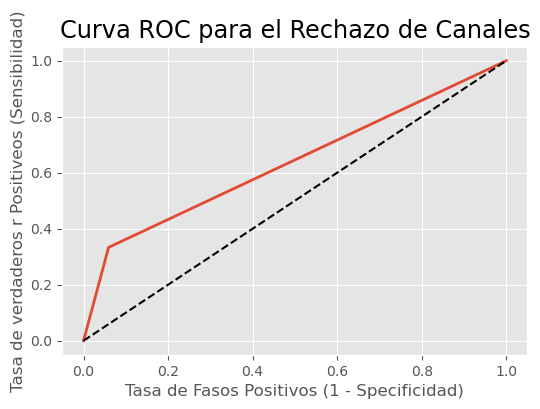

In [120]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test,  predicciones3)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('Curva ROC para el Rechazo de Canales')
plt.xlabel('Tasa de Fasos Positivos (1 - Specificidad)')
plt.ylabel('Tasa de verdaderos r Positiveos (Sensibilidad)')
plt.show()

In [122]:
print("AUC")
roc_auc_score(y_test,predicciones3)

AUC


0.6370458135860979